In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import glob
import os
import re

cwd = os.getcwd()

%matplotlib inline

In [2]:
SAMPLE_SIZE = 5090
SPLIT_RATIO = 0.7

IMAGE_SIZE = 256
BATCH_SIZE = 16

In [3]:
index = np.arange(SAMPLE_SIZE) + 1
np.random.seed(1234)
np.random.shuffle(index)

split = (int) (SAMPLE_SIZE * SPLIT_RATIO)
x_train_idx = index[0:split]
x_test_idx = index[split:]

In [4]:
def read_image(image_file):
    image = Image.open(image_file).convert('L')
    image = image.convert()
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.asarray(image).reshape((IMAGE_SIZE, IMAGE_SIZE, 1))
    return 1 - (image / 255)

In [5]:
def input_generator(indexs):
    files = glob.glob("./data/*")
    
    while(True):
        x_image = []
        y_image = []
        
        for idx in indexs:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            
            for picture in picture_files:
                image = read_image(picture)
                picture = picture.split(".")
                image_blank = read_image("." + picture[1] + "-blank." + picture[2])
                
                x_image.append(image)
                y_image.append(image_blank)

                if len(y_image) >= BATCH_SIZE:
                    yield np.array(x_image), np.array(y_image)
                    x_image = []
                    y_image = []

In [6]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop
from keras.models import Model

def generate_model():
    image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(image_input)
    img = Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    
    img = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(img)
    img = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(img)
    img = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(img)

    outputs = img

    optimizer = RMSprop()
    model = Model(inputs=image_input, outputs=outputs)
    model.compile(optimizer=optimizer,
                  loss='mse')
    
    return model

print(generate_model().summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 256, 256, 1)       289       
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
from keras.callbacks import Callback
from keras import backend as K

class TensorBoard(Callback):

    def __init__(self, log_dir='./logs',
                 write_graph=False,
                 start_steps=0,
                 batch_freq=1):
        super(TensorBoard, self).__init__()
        
        global tf, projector
        import tensorflow as tf
        from tensorflow.contrib.tensorboard.plugins import projector
        
        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.write_graph = write_graph
        
        self.start_steps = start_steps
        self.steps_counter = 1

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()
        
        self.merged = tf.summary.merge_all()

        if self.write_graph:
            self.writer = tf.summary.FileWriter(self.log_dir,
                                                self.sess.graph)
        else:
            self.writer = tf.summary.FileWriter(self.log_dir)
            
    def save_scalar(self, logs):
        log = logs or {}
        
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(
                summary,
                self.start_steps + self.steps_counter
            )
        self.writer.flush()
            
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_scalar(logs)
        self.steps_counter += 1

    def on_epoch_end(self, epoch, logs=None):
        self.save_scalar(logs)        

    def on_train_end(self, _):
        self.writer.close()

class ModelCheckpoint(Callback):

    def __init__(self,
                 filepath,
                 start_steps=0,
                 batch_freq=1):
        super(ModelCheckpoint, self).__init__()
        
        self.filepath = filepath
        
        self.steps_counter = 0
        self.start_steps = start_steps
        self.batch_freq = batch_freq
        
        self.steps_counter
        
    def save_model(self):
        self.model.save_weights(self.filepath, overwrite=True)
        
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_model()
        self.steps_counter += 1
        
    def on_epoch_end(self, epoch, logs=None):
        self.save_model()

In [ ]:
model = generate_model()
# model.load_weights('./model/model-ae-weight-1.hdf5')

model.fit_generator(
    input_generator(x_train_idx),
    steps_per_epoch=2524,
    validation_data=input_generator(x_test_idx),
    validation_steps=1082,
    max_queue_size=5,
    epochs=3,
    use_multiprocessing=True,
    callbacks=[
        TensorBoard(
            log_dir="./model/logs/",
            batch_freq=10
        ),
        ModelCheckpoint(
            filepath="./model/model-ae-weight-1.hdf5",
            batch_freq=60
        )
    ]
)

Epoch 1/3
2524/2524 [==============================] - 12279s 5s/step - loss: 0.0016 - val_loss: 3.8548e-04
Epoch 2/3
2524/2524 [==============================] - 12284s 5s/step - loss: 3.3569e-04 - val_loss: 2.3535e-04
Epoch 3/3
2524/2524 [==============================] - 12279s 5s/step - loss: 2.1869e-04 - val_loss: 1.6056e-04


In [12]:
print("!")

!


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


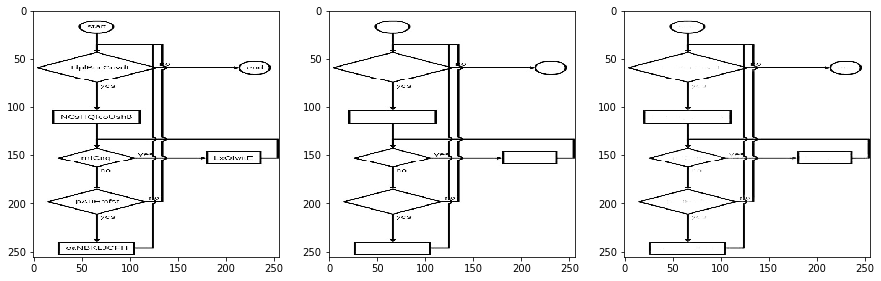

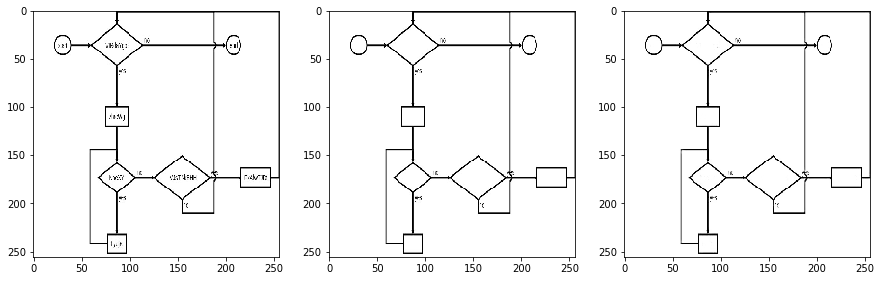

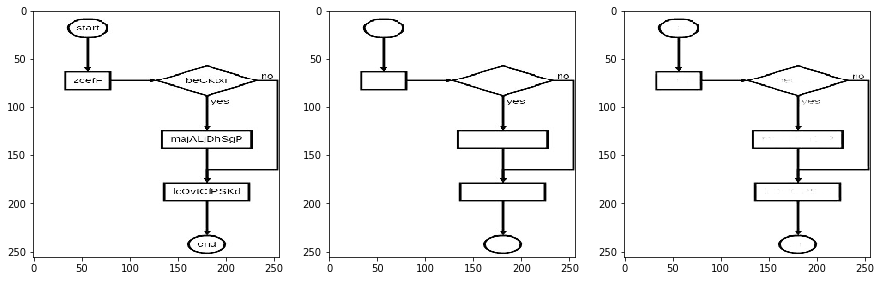

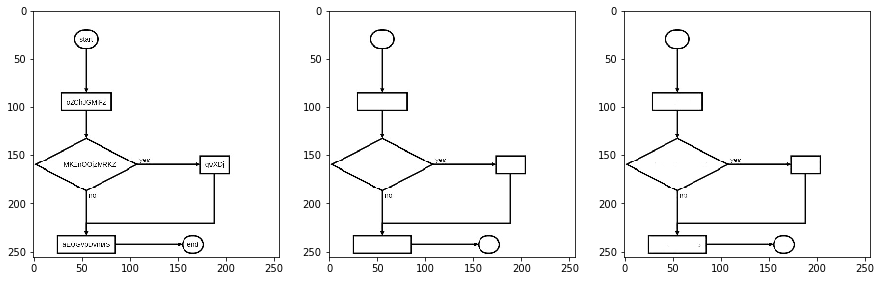

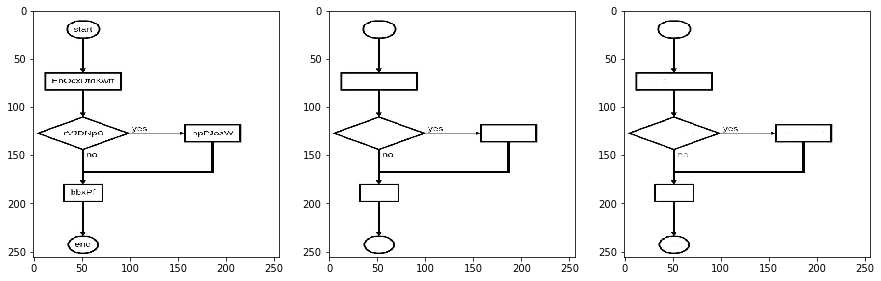

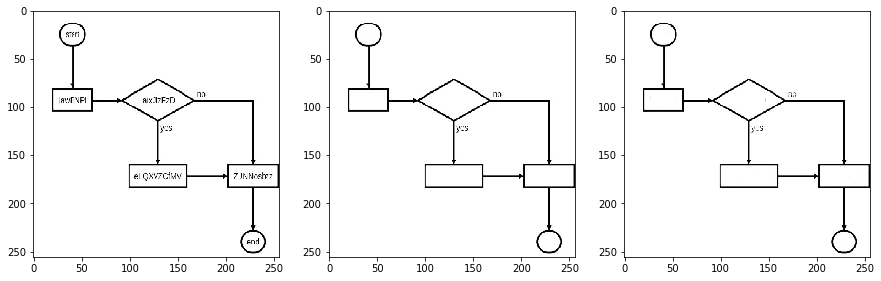

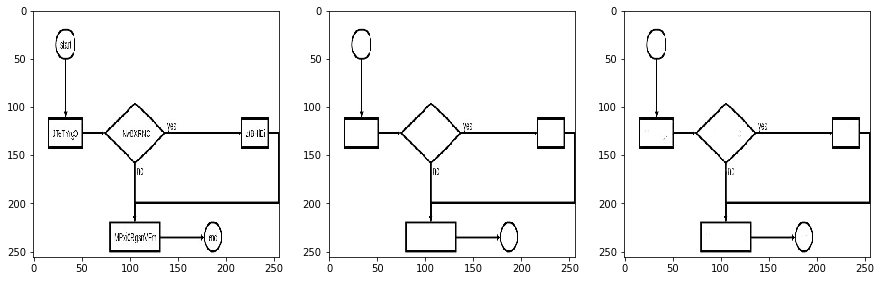

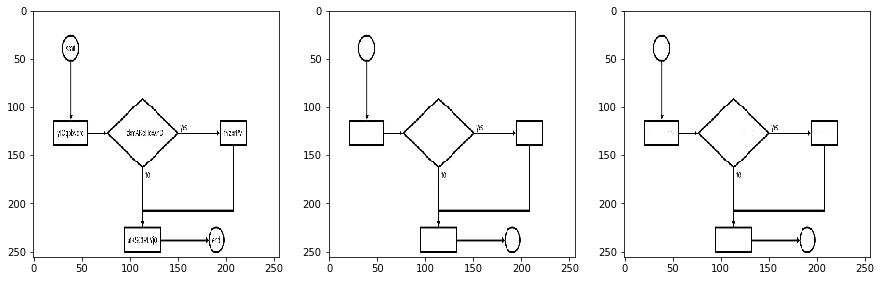

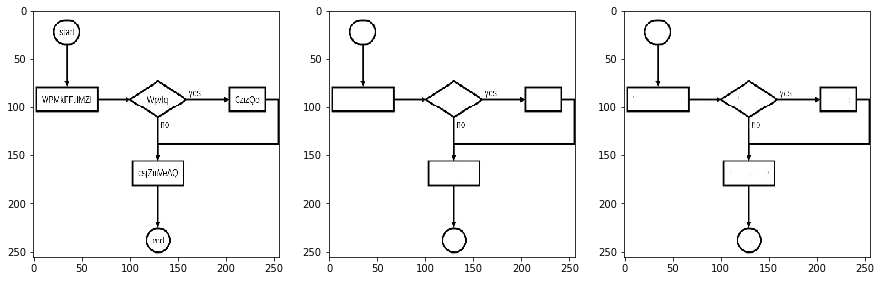

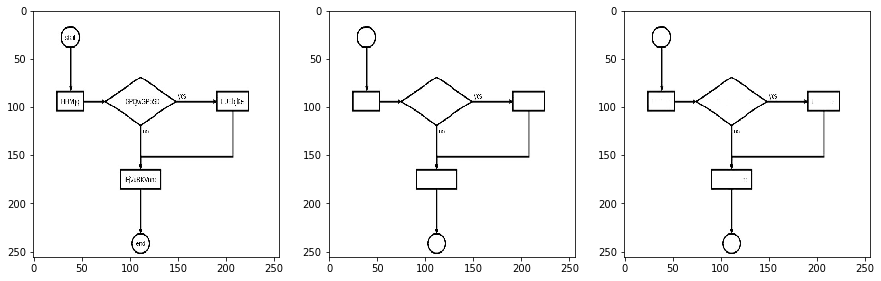

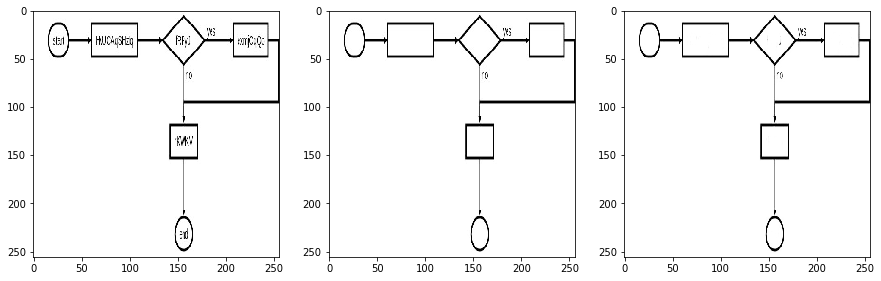

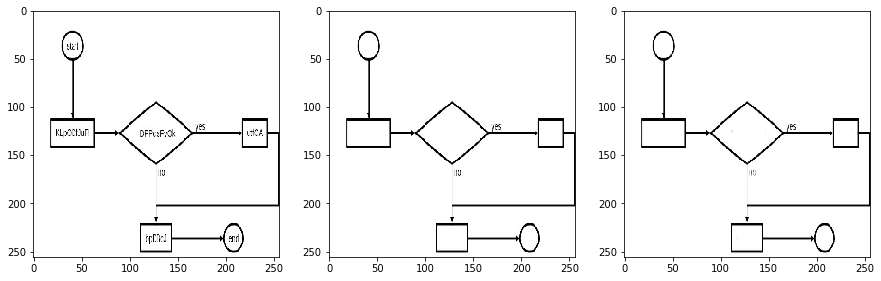

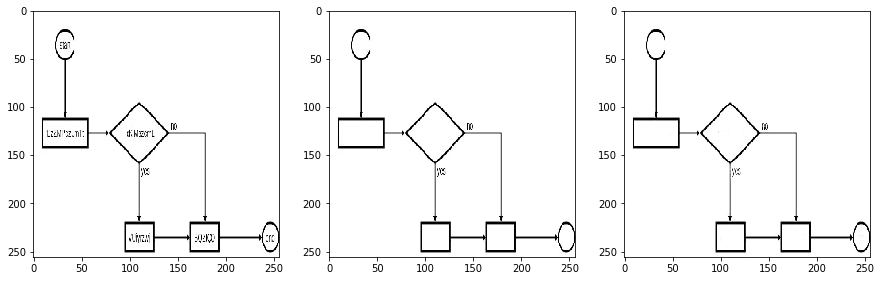

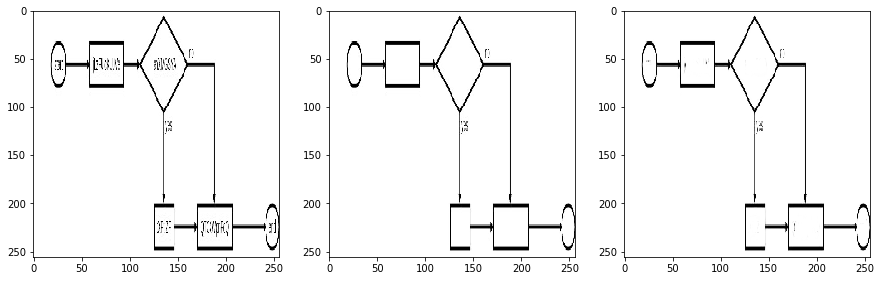

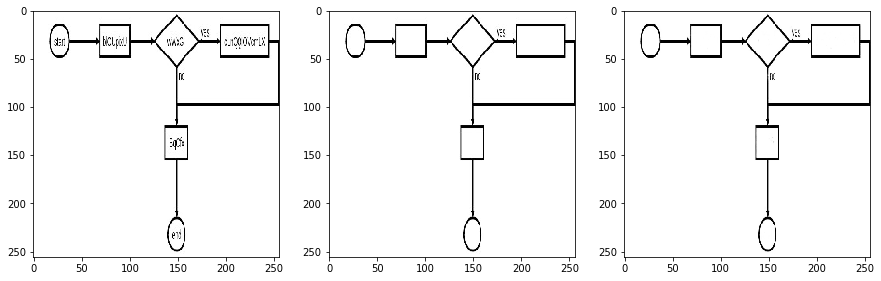

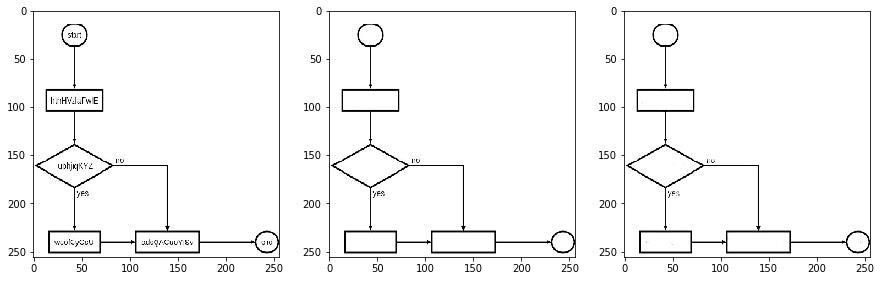

In [13]:
for x,y in input_generator(x_test_idx):
    print(y[0].reshape(IMAGE_SIZE * IMAGE_SIZE)[0:50])
    for i in range(x.shape[0]):
        xs = x[i].reshape((IMAGE_SIZE, IMAGE_SIZE))
        ys = model.predict(xs.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 1)))
        ys = ys[0].reshape((IMAGE_SIZE, IMAGE_SIZE))
        
        yss = y[i].reshape((IMAGE_SIZE, IMAGE_SIZE))

#         plt.imshow(xs)
#         plt.show()
#         plt.imshow(ys)
#         plt.show()
        
        f, axarr = plt.subplots(1,3,figsize=(15,45))
        axarr[0].imshow(xs, cmap='Greys')
        axarr[1].imshow(yss, cmap='Greys')
        axarr[2].imshow(ys, cmap='Greys')
    break